In [303]:
import os
import pandas as pd

from math import sqrt
import numpy as np
from scipy.stats import norm

import seaborn as sns

from datetime import datetime, timezone, timedelta
import time


# Numerical methods for American options

#from functions.BS_pricer import BS_pricer
#from functions.Parameters import Option_param
#from functions.Processes import Diffusion_process
#from functions.cython.cython_functions import PSOR

import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))


In [304]:
ticker = 'GOOG'
rfr = []

# 2 weeks, 1m, 3m, 6m, 1yr
expiration_datetime = []
expiration_datetime.append(datetime(2020, 12, 18, 0, 0, tzinfo=timezone.utc))
expiration_datetime.append(datetime(2021, 1, 8, 0, 0, tzinfo=timezone.utc))
expiration_datetime.append(datetime(2021, 3, 19, 0, 0, tzinfo=timezone.utc))
expiration_datetime.append(datetime(2021, 6, 18, 0, 0, tzinfo=timezone.utc))
expiration_datetime.append(datetime(2021, 10, 15, 0, 0, tzinfo=timezone.utc))

In [305]:
# get a UTC timestamp from a date. This is used to scrape data from Yahoo Finance.

expiration_timestamp = []
for x in expiration_datetime:
    expiration_timestamp.append(int(x.timestamp()))

print(expiration_timestamp)
for x in expiration_timestamp:
    print(datetime.fromtimestamp(x)) # this is in UTC, add 5 hours to this to get EST

[1608249600, 1610064000, 1616112000, 1623974400, 1634256000]
2020-12-17 19:00:00
2021-01-07 19:00:00
2021-03-18 20:00:00
2021-06-17 20:00:00
2021-10-14 20:00:00


## Below we create the data fram from the yahoo historical data.

Download historical stock price data for Google (GOOG). I get a past year's worth from (https://finance.yahoo.com/quote/GOOG/history?p=GOOG)

In [306]:
# 1

# download annual historical data for the stock

# stock_price_path = "~/documents/quant_finance/price_data/{}.csv".format(ticker)
stock_price_path = "price_data/{}.csv".format(ticker)
options_data_path = []
for x in expiration_timestamp:
    options_data_path.append('https://finance.yahoo.com/quote/{}/options?date={}&p={}'.format(ticker, x, ticker))

df = pd.read_csv(stock_price_path)
df = df.sort_values(by="Date")
df = df.dropna()

# calculate returns
df = df.assign(close_day_before=df['Adj Close'].shift(1))

# percent change in price from day before
df['returns'] = ((df['Adj Close'] - df.close_day_before)/df.close_day_before)
#get rid of first day in data, since we can't find price from day before
df = df.dropna()
df = df.drop(['Open','High','Low','Close'],axis=1)

# get options data, save
print(options_data_path)
options_data = []
for i,x in enumerate(options_data_path):
    options_df_list = pd.read_html(x)
    options_data.append(options_df_list) # returns two dataframes, for calls and puts
    collection_date = str(datetime.now().date())
    save_path = "price_data/{}".format(collection_date)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    options_df_list[0].to_csv("price_data/{}/{}_{}_calls.csv".format(collection_date, ticker, expiration_timestamp[i]))
    options_df_list[1].to_csv("price_data/{}/{}_{}_puts.csv".format(collection_date, ticker, expiration_timestamp[i]))
    
    time.sleep(1)

calls_df = []
puts_df = []
for x in options_data:

    x[0]['Volume'] = x[0]['Volume'].replace('-','0')
    x[0] = x[0].replace('-',np.NaN)
    x[1]['Volume'] = x[1]['Volume'].replace('-','0')
    x[1] = x[1].replace('-',np.NaN)
    x[1]['Implied Volatility'] = x[1]['Implied Volatility'].str.slice(stop=-1)
    x[0]['Implied Volatility'] = x[0]['Implied Volatility'].str.slice(stop=-1)
    x[1]['Implied Volatility'] = x[1]['Implied Volatility'].astype(float)/100
    x[0]['Implied Volatility'] = x[0]['Implied Volatility'].astype(float)/100
    
    
    #x[1]['Implied Volatility'] = x[1]['Implied Volatility'].replace(0,10**(-3))
    #x[0]['Implied Volatility'] = x[0]['Implied Volatility'].replace(0,10**(-3))
    
    x[1] = x[1][x[1]['Implied Volatility'] != 0].reset_index()
    x[0] = x[0][x[0]['Implied Volatility'] != 0].reset_index()

 
    # code for filtering the options data to be only actively traded options

#    x[0] = x[0][(x[0]['Open Interest'].astype('int') > 15)].reset_index()
#    x[0] = x[0][(x[0]['Volume'].astype('int') > 1)].reset_index()
#    x[1] = x[1][(x[1]['Open Interest'].astype('int') > 15)].reset_index()
#    x[1] = x[1][(x[1]['Volume'].astype('int') > 1)].reset_index()
    
    calls_df.append(x[0])
    puts_df.append(x[1])

##add the new item, the Mid Price
for df_list in [calls_df, puts_df]:
    for x in df_list:
        x['Mid Price'] = (x['Ask'] + x['Bid'])/2
#print(df)
#print(calls_df)
#print(puts_df)

['https://finance.yahoo.com/quote/GOOG/options?date=1608249600&p=GOOG', 'https://finance.yahoo.com/quote/GOOG/options?date=1610064000&p=GOOG', 'https://finance.yahoo.com/quote/GOOG/options?date=1616112000&p=GOOG', 'https://finance.yahoo.com/quote/GOOG/options?date=1623974400&p=GOOG', 'https://finance.yahoo.com/quote/GOOG/options?date=1634256000&p=GOOG']


       Date  1 mo  2 mo  3 mo  6 mo  1 yr  2 yr  3 yr  5 yr  7 yr  10 yr  \
0  12/01/20  0.07  0.07  0.09  0.10  0.12  0.17  0.22  0.42  0.68   0.92   
1  12/02/20  0.07  0.08  0.09  0.10  0.11  0.16  0.22  0.42  0.69   0.95   
2  12/03/20  0.08  0.08  0.08  0.09  0.10  0.16  0.21  0.40  0.67   0.92   
3  12/04/20  0.07  0.07  0.09  0.10  0.11  0.16  0.21  0.42  0.70   0.97   
4  12/07/20  0.09  0.08  0.08  0.10  0.10  0.14  0.20  0.40  0.67   0.94   

   20 yr  30 yr  
0   1.46   1.66  
1   1.50   1.70  
2   1.46   1.67  
3   1.53   1.73  
4   1.49   1.69  


<AxesSubplot:title={'center':'Treasury Curve for 12/04/20'}>

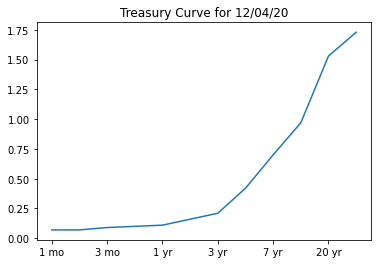

In [307]:
# 2
# get risk free rate data

rfr_data_path = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
rfr_df = pd.read_html(rfr_data_path)[1]
print(rfr_df)

# next we plot the rfr

# find the date from this data
rfr_date = rfr_df.iloc[3][0]

cur_rfr = rfr_df.iloc[3][1:].astype(float)
cur_rfr.plot(title="Treasury Curve for {}".format(rfr_date))

In [308]:
# 3
# BSM model algorithm using SciPy for the normal distribution
# Explicit formula for solving European Option Prices

# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma, option_type):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type=='call':
        return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)
    elif option_type=='put':
        return K*np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
        
# get the (num days to expiration) / (trading days in a year)
def get_time_to_expiration(expiration_datetime_utc):
    return (expiration_datetime_utc - datetime.now(timezone.utc)).days / 252


In [309]:
# 4

# the rfr should vary with time, not be constant.
rfr = []
for x in [1,1,3,4,5]:
    rfr.append(rfr_df.iloc[3][x].astype(float))
    
# Adjust the 2-week expiration rfr
rfr[0] = rfr[0]/2
    
cur_stock_price = df.iloc[-1]['Adj Close']
time_to_expiration = []
for x in expiration_datetime:
    time_to_expiration.append(get_time_to_expiration(x))

# Calculate the volatility as the annualized standard deviation of the stock returns
## The stock market has had a crazy year, perhaps we want the volatility to be measured only in the last 6 months. 
sigma = np.sqrt(252) * df['returns'].std()

## Do interest rates need to be adjusted with day counts? need to look into this

rfr_time = tuple(zip(time_to_expiration, rfr))

for x in rfr_time:
    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, sigma: {}'.format(cur_stock_price, x[0], x[1], sigma))

#calls_index = []
#puts_index = []
#for x in calls_df:
#    strike_start_idx, strike_end_idx = 0, x.shape[0]
#    calls_index.append((strike_start_idx,strike_end_idx))
    
#for x in puts_df:
#    strike_start_idx, strike_end_idx = 0, x.shape[0]
#    puts_index.append((strike_start_idx,strike_end_idx))

cur_stock_price: 1826.77002, time to expiration: 0.03571428571428571, rfr: 0.035, sigma: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 0.11904761904761904, rfr: 0.07, sigma: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 0.3968253968253968, rfr: 0.09, sigma: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 0.7579365079365079, rfr: 0.1, sigma: 0.3787231343934279
cur_stock_price: 1826.77002, time to expiration: 1.2301587301587302, rfr: 0.11, sigma: 0.3787231343934279


In [310]:
# binomial trees

def price_american_binomial_tree(S0, K, T, r, sig, payoff='call', N = 8000):
    
    dT = float(T) / N                             # Delta t
    u = np.exp(sig * np.sqrt(dT))                 # up factor
    d = 1.0 / u                                   # down factor 

    V = np.zeros(N+1)                             # initialize the price vector
    S_T = np.array( [(S0 * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

    a = np.exp(r * dT)    # risk free compound return
    p = (a - d)/ (u - d)  # risk neutral up probability
    q = 1.0 - p           # risk neutral down probability   

    if payoff =="call":
        V[:] = np.maximum(S_T-K, 0.0)
    elif payoff =="put":
        V[:] = np.maximum(K-S_T, 0.0)

    for i in range(N-1, -1, -1):
        V[:-1] = np.exp(-r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
        S_T = S_T * u                    # it is a tricky way to obtain the price at the previous time step
        if payoff=="call":
            V = np.maximum( V, S_T-K )
        elif payoff=="put":
            V = np.maximum( V, K-S_T )

#     print("American BS Tree Price: ", V[0])
    
    return V[0]

In [311]:
## test the code

S0=100.0    # spot stock price
K=100.0     # strike
T=1.0       # maturity 
r=0.1       # risk free rate 
sig=0.2     # diffusion coefficient or volatility

N = 25000              # number of periods or number of time steps  
payoff = "put"        # payoff 

price_american_binomial_tree(S0, K, T, r, sig, payoff='call', N = 8000)

In [312]:
# plot as we vary N

iterations = [500,1000, 2000, 4000, 8000, 16000, 25000]
prices = []
runtimes = []

for N in iterations:
    start = time.perf_counter()
    price = price_american_binomial_tree(S0, K, T, r, sig, payoff='call', N = N)
    runtimes.append(time.perf_counter() - start)
    prices.append(price)

df_btree = pd.DataFrame({'N':iterations, 'price':prices, 'runtime':runtimes})
df_btree.head()

,N,price,runtime
0,500,13.265501,0.006420
1,1000,13.267589,0.014074
2,2000,13.268633,0.034755
3,4000,13.269155,0.102856
4,8000,13.269416,0.397325


Text(0, 0.5, 'error')

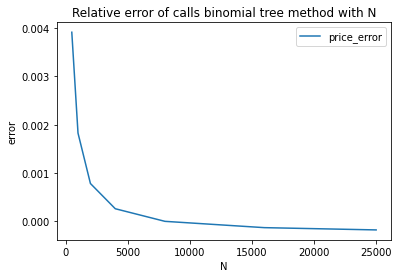

In [313]:
df_btree['price_error'] = df_btree['price'][4] - df_btree['price']
ax1 = df_btree.plot(x='N',y=['price_error'])
ax1.set_title("Relative error of calls binomial tree method with N")
ax1.set_ylabel("error")

Text(0, 0.5, 'runtime (s)')

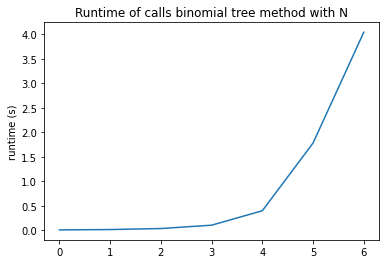

In [314]:
ax2 = df_btree['runtime'].plot() 
ax2.set_title("Runtime of calls binomial tree method with N")
ax2.set_ylabel("runtime (s)")

In [315]:
# plot as we vary N

iterations = [500,1000, 2000, 4000, 8000, 16000, 25000]
prices = []
runtimes = []

for N in iterations:
    start = time.perf_counter()
    price = price_american_binomial_tree(S0, K, T, r, sig, payoff='put', N = N)
    runtimes.append(time.perf_counter() - start)
    prices.append(price)

df_btree = pd.DataFrame({'N':iterations, 'price':prices, 'runtime':runtimes})
df_btree.head()

,N,price,runtime
0,500,4.814701,0.006289
1,1000,4.815466,0.014958
2,2000,4.815879,0.038301
3,4000,4.816082,0.114320
4,8000,4.816182,0.354154


Text(0, 0.5, 'error')

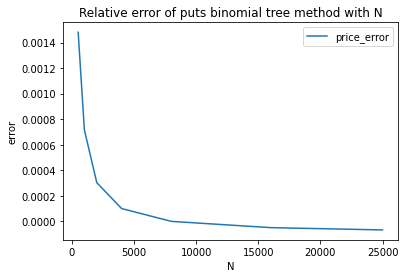

In [316]:
df_btree['price_error'] = df_btree['price'][4] - df_btree['price']
ax1 = df_btree.plot(x='N',y=['price_error'])
ax1.set_title("Relative error of puts binomial tree method with N")
ax1.set_ylabel("error")

Text(0, 0.5, 'runtime (s)')

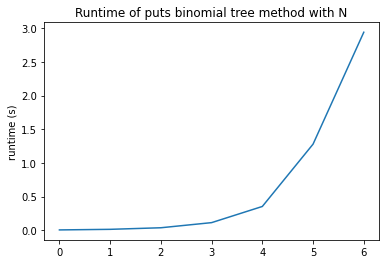

In [317]:
ax2 = df_btree['runtime'].plot() 
ax2.set_title("Runtime of puts binomial tree method with N")
ax2.set_ylabel("runtime (s)")

In [318]:
# PDE method

def price_american(S0, K, T, r, sigma, payoff, model='binomial_tree'):
    
    if model == 'binomial_tree':
        return price_american_binomial_tree(S0, K, T, r, sigma, payoff=payoff, N=800)
    elif model == 'PDE':
        return price_american_PDE(S0, K, T, r, sigma, payoff=payoff, N_space = 4000, N_time = 2000)


In [319]:
%%time

# if we use implied vol instead of historical vol, our estimate should improve

def calculate_prices_across_strikes_american(options_df, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type, model):

    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
    index = []
    list_estimates = []
    list_estimates_implied = []

    strike_start_idx, strike_end_idx = 0, options_df.shape[0]
    #step = 1

    # run BSM for different strikes
    #for x in range(strike_start_idx,strike_end_idx, step):
    for x in range(strike_start_idx,strike_end_idx):
        index.append(x)
        value_s = price_american(S0 = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = sigma,
                                payoff = option_type,
                                model = model)
        list_estimates.append(value_s)
        
        # same calcs but with implied vol
        value_s_implied = price_american(S0 = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = options_df['Implied Volatility'][x],
                                payoff = option_type,
                                model = model)
        list_estimates_implied.append(value_s_implied)

        
        
    # merge the real and computed dataframes to compare results
    price_estimates = pd.DataFrame(data=list_estimates, index=index)
    price_estimates_implied = pd.DataFrame(data=list_estimates_implied, index=index)
    price_estimates.rename(columns={price_estimates.columns[0]: 'Estimate'},inplace = True)
    price_estimates_implied.rename(columns={price_estimates_implied.columns[0]: 'Estimate With IV'},inplace = True)

    df_estimate = options_df.copy(deep=True)
    df_estimate = df_estimate.loc[:, df.columns.intersection(['Strike','Mid Price','Last Price'])]
    
    df_estimate = df_estimate.merge(price_estimates, right_index = True, left_index = True)
    df_estimate = df_estimate.merge(price_estimates_implied, right_index = True, left_index = True)

    return df_estimate

Wall time: 0 ns


cur_stock_price: 1826.77002, time to expiration: 0.03571428571428571, rfr: 0.035, vol: 0.3787231343934279


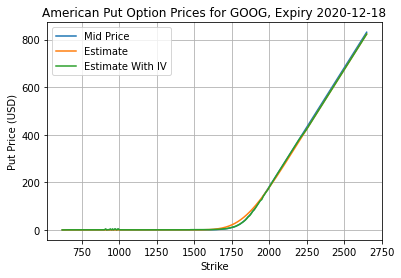

cur_stock_price: 1826.77002, time to expiration: 0.11904761904761904, rfr: 0.07, vol: 0.3787231343934279


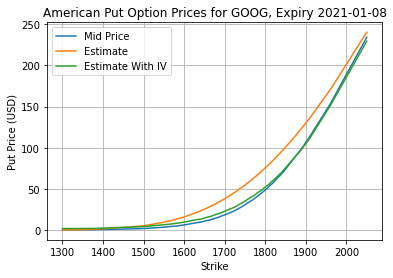

cur_stock_price: 1826.77002, time to expiration: 0.3968253968253968, rfr: 0.09, vol: 0.3787231343934279


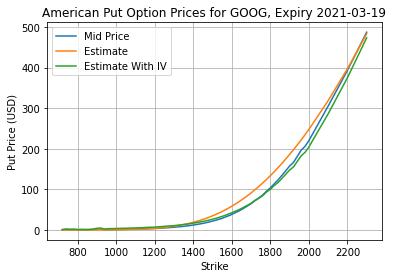

cur_stock_price: 1826.77002, time to expiration: 0.7579365079365079, rfr: 0.1, vol: 0.3787231343934279


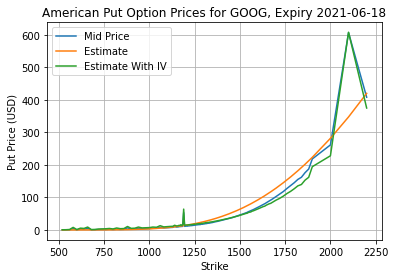

cur_stock_price: 1826.77002, time to expiration: 1.2301587301587302, rfr: 0.11, vol: 0.3787231343934279


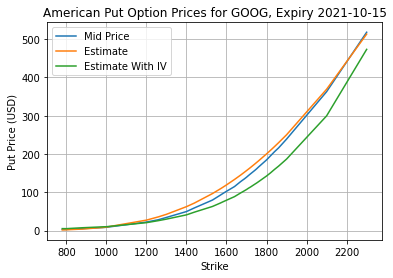

Wall time: 13 s


In [320]:
%%time

#store a list of these estimates so I don't need to run it again
american_put_estimates = []

#print(puts_df[0])

for i,df in enumerate(puts_df):
    option_type = 'put'
    df_estimate_american = calculate_prices_across_strikes_american(df, cur_stock_price, time_to_expiration[i], rfr[i], sigma, option_type, model='binomial_tree')
    american_put_estimates.append(df_estimate_american)
    
    ax1 = df_estimate_american.plot(kind='line', x='Strike', y=['Mid Price', 'Estimate', 'Estimate With IV'], title='American Put Option Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylabel('Put Price (USD)')
    plt.show()
    


cur_stock_price: 1826.77002, time to expiration: 0.03571428571428571, rfr: 0.035, vol: 0.3787231343934279


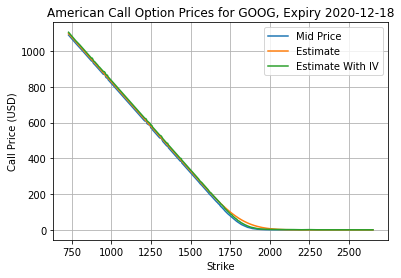

cur_stock_price: 1826.77002, time to expiration: 0.11904761904761904, rfr: 0.07, vol: 0.3787231343934279


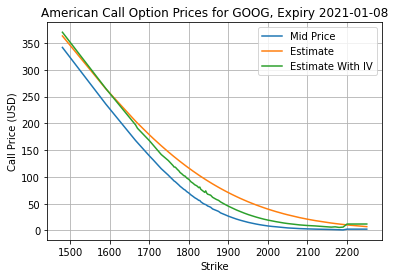

cur_stock_price: 1826.77002, time to expiration: 0.3968253968253968, rfr: 0.09, vol: 0.3787231343934279


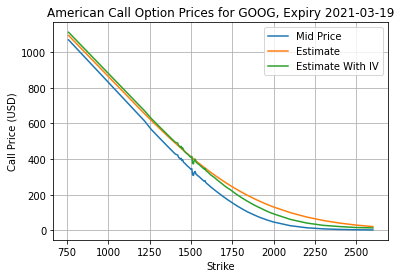

cur_stock_price: 1826.77002, time to expiration: 0.7579365079365079, rfr: 0.1, vol: 0.3787231343934279


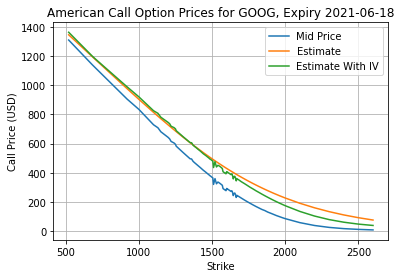

cur_stock_price: 1826.77002, time to expiration: 1.2301587301587302, rfr: 0.11, vol: 0.3787231343934279


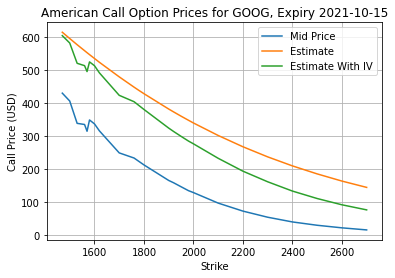

Wall time: 9.88 s


In [321]:
%%time

#store a list of these estimates so I don't need to run it again
american_call_estimates = []

#print(puts_df[0])

for i,df in enumerate(calls_df):
    option_type = 'call'
    df_estimate_american = calculate_prices_across_strikes_american(df, cur_stock_price, time_to_expiration[i], rfr[i], sigma, option_type, model='binomial_tree')
    american_call_estimates.append(df_estimate_american)
    
    ax1 = df_estimate_american.plot(kind='line', x='Strike', y=['Mid Price', 'Estimate', 'Estimate With IV'], title='American Call Option Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylabel('Call Price (USD)')
    plt.show()
    

## We find the percent error in the price of the Estimate and Estimate With IV

In [322]:
features = ['Last Price','Mid Price']

for feature in features:
    for df_list in [american_put_estimates, american_call_estimates]:
        for df in df_list:
            feature_error_name = feature + " Estimate Error"
            df[feature_error_name] = ((abs(df[feature] - df['Estimate'])/df['Estimate']))*100

In [323]:
features = ['Last Price','Mid Price']

for feature in features:
    for df_list in [american_put_estimates, american_call_estimates]:
        for df in df_list:
            feature_error_name = feature + " Estimate With IV Error"
            df[feature_error_name] = ((abs(df[feature] - df['Estimate With IV'])/df['Estimate With IV']))*100

## Plotting the percent error in Estimate and Estimates With IV for American Puts

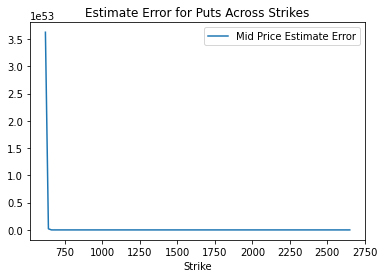

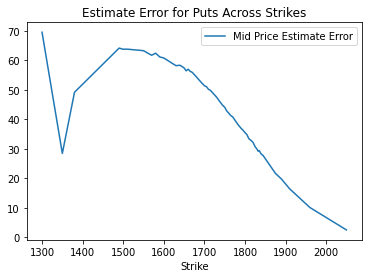

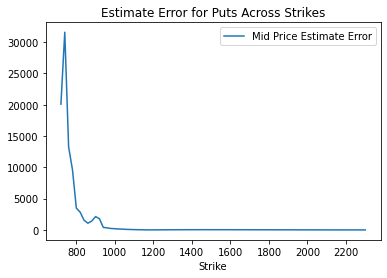

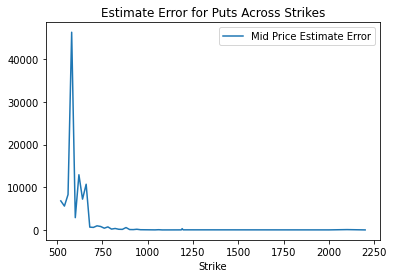

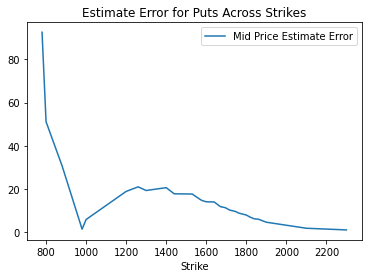

In [324]:
for i in range(0,5):
    #american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate Error','Last Price Estimate Error'],title='Estimate Error for Puts Across Strikes')
    american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate Error'],title='Estimate Error for Puts Across Strikes')

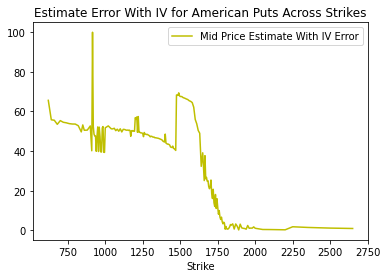

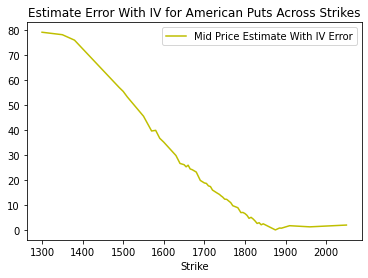

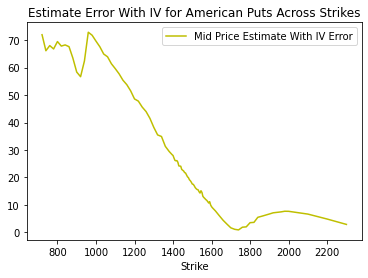

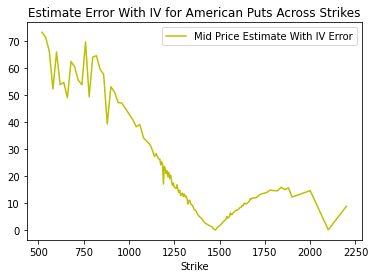

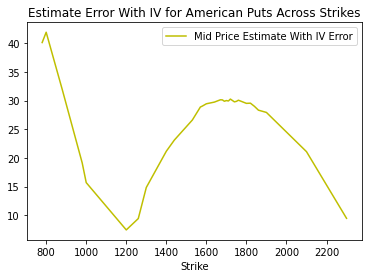

In [325]:
for i in range(0,5):
    #american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error','Last Price Estimate With IV Error'],title='Estimate Error With IV for American Puts Across Strikes')
    american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error'],title='Estimate Error With IV for American Puts Across Strikes', color = 'y')

## Plotting the percent error in Estimate and Estimates With IV for American Calls

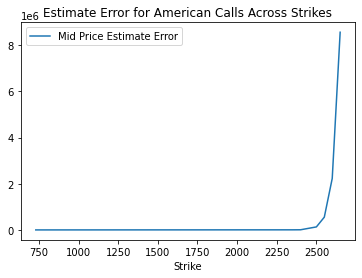

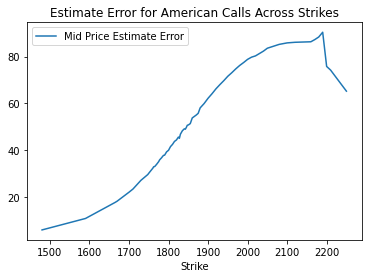

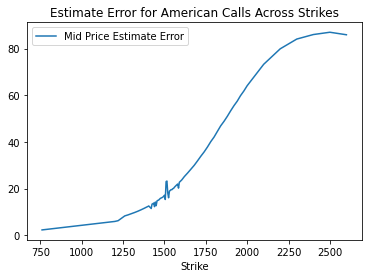

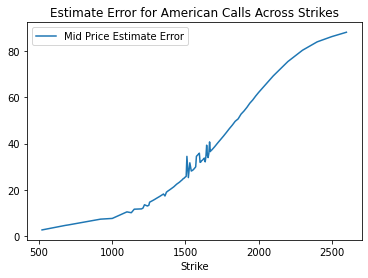

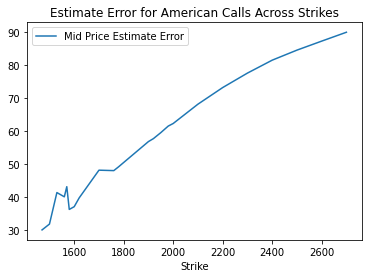

In [326]:
for i in range(0,5):
    #american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate Error','Last Price Estimate Error'],title='Estimate Error for Puts Across Strikes')
    american_call_estimates[i].plot(x='Strike',y=['Mid Price Estimate Error'],title='Estimate Error for American Calls Across Strikes')

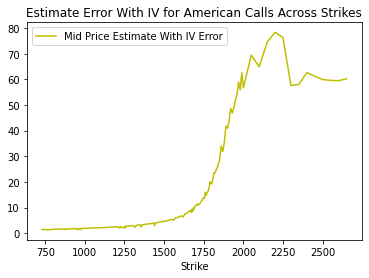

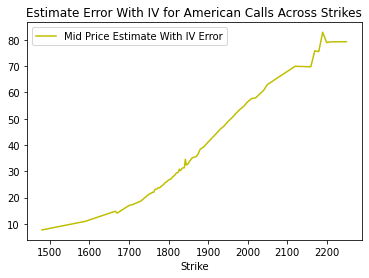

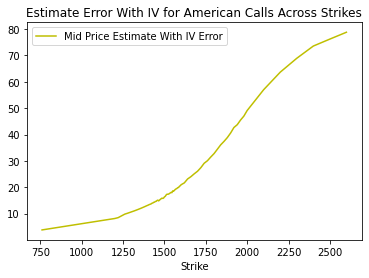

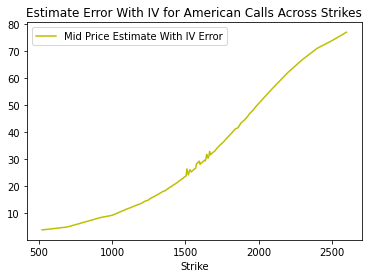

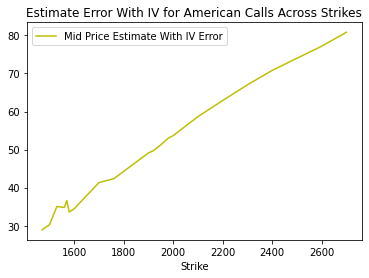

In [327]:
for i in range(0,5):
    #american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error','Last Price Estimate With IV Error'],title='Estimate Error With IV for American Puts Across Strikes')
    american_call_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error'],title='Estimate Error With IV for American Calls Across Strikes', color='y')

## Finding more Error Statistics for the Estimate Error

In [328]:
# median and IQR percent error

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def get_error(df):
    
    predictions, targets = df['Estimate'], df['Mid Price']
#     percent_error = ((abs(targets - predictions)/targets))*100
    percent_error = df['Mid Price Estimate Error']
    Q1 = percent_error.quantile(0.25)
    Q3 = percent_error.quantile(0.75)
    IQR = Q3 - Q1
    
    print('Median Error: {}, IQR of error: {}, RMSE: {}'.format(percent_error.median(), IQR, rmse(predictions, targets)))

print('calls')
for i in range(0,5):
#     print(puts_estimate_df[i]['Mid Price estimate error'].describe())
    get_error(american_call_estimates[i])
print('puts')
for i in range(0,5):
    get_error(american_put_estimates[i])

calls
Median Error: 2.7095706378840263, IQR of error: 23.788299582755105, RMSE: 13.141170279500033
Median Error: 50.19396680463653, IQR of error: 37.061657805669576, RMSE: 39.30220008121035
Median Error: 20.355067511454383, IQR of error: 22.95014915654204, RMSE: 72.54596324540753
Median Error: 31.85866073257421, IQR of error: 21.897004398954234, RMSE: 125.00411568370353
Median Error: 53.681716811364005, IQR of error: 28.349227424030644, RMSE: 202.1851588140251
puts
Median Error: 4273.643236372672, IQR of error: 12779736705.66066, RMSE: 6.062974657813043
Median Error: 45.19202403220889, IQR of error: 24.063331322053337, RMSE: 20.565080785926828
Median Error: 36.42856332497952, IQR of error: 9.825911754399655, RMSE: 15.122311221449275
Median Error: 26.192187403343787, IQR of error: 7.133684164624825, RMSE: 26.64925108525806
Median Error: 11.39713633675638, IQR of error: 10.298852671895784, RMSE: 13.309122735252267


## Finding more Error Statistics for the Estimate Error With IV

In [329]:
# median and IQR percent error

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def get_error(df):
    
    predictions, targets = df['Estimate With IV'], df['Mid Price']
#     percent_error = ((abs(targets - predictions)/targets))*100
    percent_error = df['Mid Price Estimate With IV Error']
    Q1 = percent_error.quantile(0.25)
    Q3 = percent_error.quantile(0.75)
    IQR = Q3 - Q1
    
    print('Median Error: {}, IQR of error: {}, RMSE: {}'.format(percent_error.median(), IQR, rmse(predictions, targets)))

print('calls')
for i in range(0,5):
#     print(puts_estimate_df[i]['Mid Price estimate error'].describe())
    get_error(american_call_estimates[i])
print('puts')
for i in range(0,5):
    get_error(american_put_estimates[i])

calls
Median Error: 4.507951242077036, IQR of error: 13.790333603305196, RMSE: 13.371269847418821
Median Error: 32.77909844624328, IQR of error: 28.60604182161471, RMSE: 20.960641859965264
Median Error: 18.577704291182123, IQR of error: 15.129425458163137, RMSE: 62.019468497567196
Median Error: 26.739557667420456, IQR of error: 15.17760368455987, RMSE: 104.76903607727562
Median Error: 46.706921078035066, IQR of error: 24.077240902423775, RMSE: 152.06716331339177
puts
Median Error: 46.59478348261011, IQR of error: 37.607590181590254, RMSE: 1.7973422445396023
Median Error: 14.102773544052624, IQR of error: 21.274620571878827, RMSE: 3.414271884795803
Median Error: 21.266762691108013, IQR of error: 37.568380510643536, RMSE: 5.637185526321734
Median Error: 13.671176399960748, IQR of error: 19.67659862907039, RMSE: 7.625431665982581
Median Error: 29.454612571162908, IQR of error: 7.840086480519393, RMSE: 30.972585649650075


## Here is code for doing the same for European Options

In [330]:
%%time

# if we use implied vol instead of historical vol, our estimate should improve

def calculate_prices_across_strikes_european(options_df, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type, model):

    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
    index = []
    list_estimates = []
    list_estimates_implied = []

    strike_start_idx, strike_end_idx = 0, options_df.shape[0]
    #step = 1

    # run BSM for different strikes
    #for x in range(strike_start_idx,strike_end_idx, step):
    for x in range(strike_start_idx,strike_end_idx):
        index.append(x)
        value_s = black_scholes(S = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = sigma,
                                option_type = option_type)
        list_estimates.append(value_s)
        
        # same calcs but with implied vol
        value_s_implied = black_scholes(S = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = options_df['Implied Volatility'][x],
                                option_type = option_type)
        list_estimates_implied.append(value_s_implied)

        
        
    # merge the real and computed dataframes to compare results
    price_estimates = pd.DataFrame(data=list_estimates, index=index)
    price_estimates_implied = pd.DataFrame(data=list_estimates_implied, index=index)
    price_estimates.rename(columns={price_estimates.columns[0]: 'Estimate (EU)'},inplace = True)
    price_estimates_implied.rename(columns={price_estimates_implied.columns[0]: 'Estimate With IV (EU)'},inplace = True)

    df_estimate = options_df.copy(deep=True)
    df_estimate = df_estimate.loc[:, df.columns.intersection(['Strike','Mid Price', 'Last Price'])]
    
    df_estimate = df_estimate.merge(price_estimates, right_index = True, left_index = True)
    df_estimate = df_estimate.merge(price_estimates_implied, right_index = True, left_index = True)

    return df_estimate

Wall time: 0 ns


## Below I will recalculate the European Options Data

cur_stock_price: 1826.77002, time to expiration: 0.03571428571428571, rfr: 0.035, vol: 0.3787231343934279


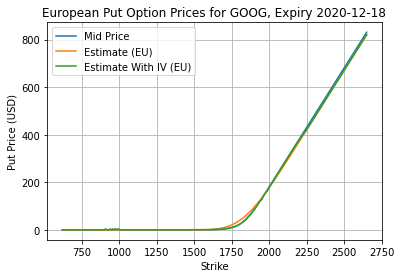

cur_stock_price: 1826.77002, time to expiration: 0.11904761904761904, rfr: 0.07, vol: 0.3787231343934279


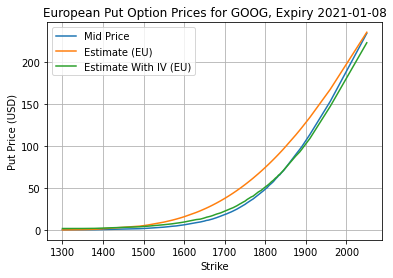

cur_stock_price: 1826.77002, time to expiration: 0.3968253968253968, rfr: 0.09, vol: 0.3787231343934279


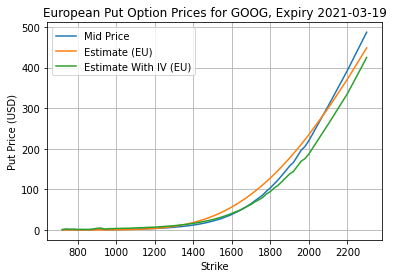

cur_stock_price: 1826.77002, time to expiration: 0.7579365079365079, rfr: 0.1, vol: 0.3787231343934279


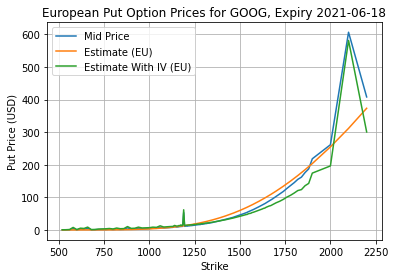

cur_stock_price: 1826.77002, time to expiration: 1.2301587301587302, rfr: 0.11, vol: 0.3787231343934279


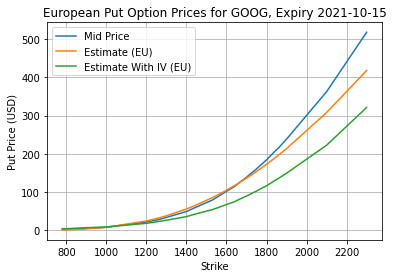

Wall time: 812 ms


In [331]:
%%time

#store a list of these estimates so I don't need to run it again
european_put_estimates = []

#print(puts_df[0])

for i,df in enumerate(puts_df):
    option_type = 'put'
    df_estimate_european = calculate_prices_across_strikes_european(df, cur_stock_price, time_to_expiration[i], rfr[i], sigma, option_type, model='binomial_tree')
    european_put_estimates.append(df_estimate_european)
    
    ax1 = df_estimate_european.plot(kind='line', x='Strike', y=['Mid Price', 'Estimate (EU)', 'Estimate With IV (EU)'], title='European Put Option Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylabel('Put Price (USD)')
    plt.show()
    

cur_stock_price: 1826.77002, time to expiration: 0.03571428571428571, rfr: 0.035, vol: 0.3787231343934279


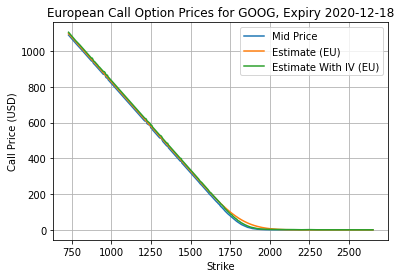

cur_stock_price: 1826.77002, time to expiration: 0.11904761904761904, rfr: 0.07, vol: 0.3787231343934279


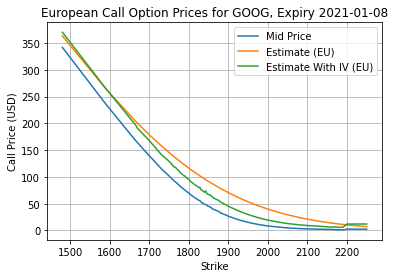

cur_stock_price: 1826.77002, time to expiration: 0.3968253968253968, rfr: 0.09, vol: 0.3787231343934279


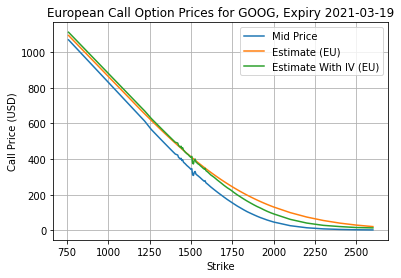

cur_stock_price: 1826.77002, time to expiration: 0.7579365079365079, rfr: 0.1, vol: 0.3787231343934279


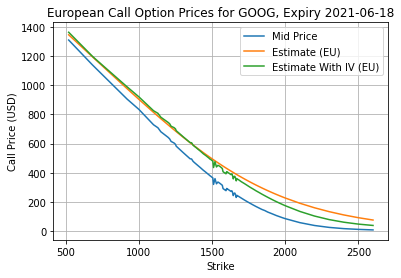

cur_stock_price: 1826.77002, time to expiration: 1.2301587301587302, rfr: 0.11, vol: 0.3787231343934279


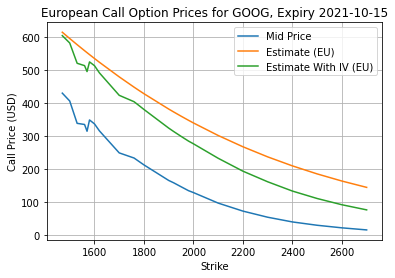

Wall time: 817 ms


In [332]:
%%time

#store a list of these estimates so I don't need to run it again
european_call_estimates = []

#print(puts_df[0])

for i,df in enumerate(calls_df):
    option_type = 'call'
    df_estimate_european = calculate_prices_across_strikes_european(df, cur_stock_price, time_to_expiration[i], rfr[i], sigma, option_type, model='binomial_tree')
    european_call_estimates.append(df_estimate_european)
    
    ax1 = df_estimate_european.plot(kind='line', x='Strike', y=['Mid Price', 'Estimate (EU)', 'Estimate With IV (EU)'], title='European Call Option Prices for {}, Expiry {}'.format(ticker, expiration_datetime[i].date()))
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylabel('Call Price (USD)')
    plt.show()
    

In [333]:
features = ['Last Price','Mid Price']

for feature in features:
    for df_list in [european_put_estimates, european_call_estimates]:
        for df in df_list:
            feature_error_name = feature + " Estimate Error (EU)"
            df[feature_error_name] = ((abs(df[feature] - df['Estimate (EU)'])/df['Estimate (EU)']))*100

for feature in features:
    for df_list in [european_put_estimates, european_call_estimates]:
        for df in df_list:
            feature_error_name = feature + " Estimate With IV Error (EU)"
            df[feature_error_name] = ((abs(df[feature] - df['Estimate With IV (EU)'])/df['Estimate With IV (EU)']))*100

## We will compare the percent error in the data using implied volatility of the European and American Puts 

In [334]:
## Compare American and European Error

#df_estimate_american['european_estimate'] = df_estimate_european['estimate']
#df_estimate_american['european_estimate_with_implied'] = df_estimate_european['estimate_with_implied']

for i in range(0,5):
    american_call_estimates[i] = american_call_estimates[i].merge(european_call_estimates[i], right_on = ['Strike', 'Last Price', 'Mid Price'], left_on = ['Strike', 'Last Price', 'Mid Price'])
    american_put_estimates[i] = american_put_estimates[i].merge(european_put_estimates[i], right_on = ['Strike', 'Last Price', 'Mid Price'], left_on = ['Strike', 'Last Price', 'Mid Price'])


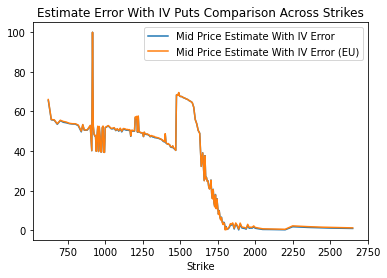

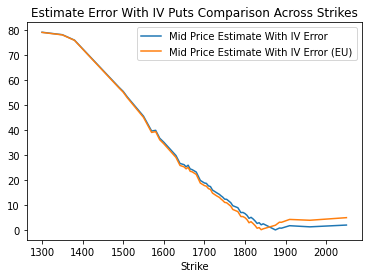

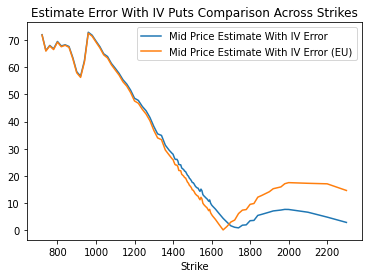

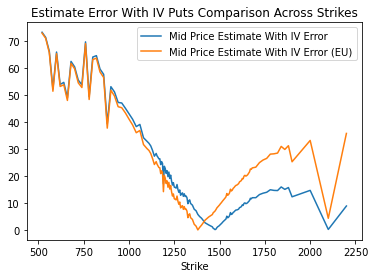

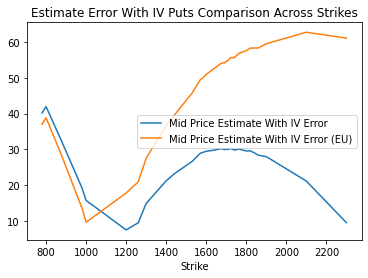

In [337]:
for i in range(0,5):
    #american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error','Last Price Estimate With IV Error'],title='Estimate Error With IV for American Puts Across Strikes')
    american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error', 'Mid Price Estimate With IV Error (EU)'],title='Estimate Error With IV Puts Comparison Across Strikes')

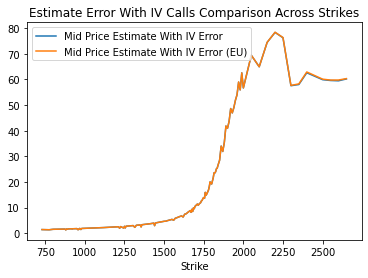

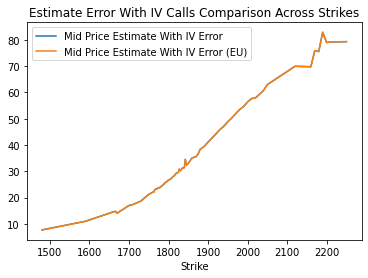

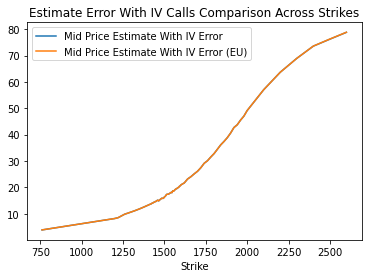

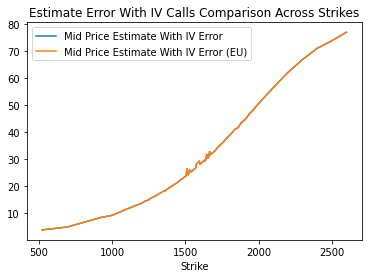

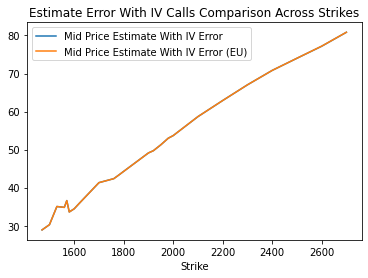

In [338]:
for i in range(0,5):
    #american_put_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error','Last Price Estimate With IV Error'],title='Estimate Error With IV for American Puts Across Strikes')
    american_call_estimates[i].plot(x='Strike',y=['Mid Price Estimate With IV Error', 'Mid Price Estimate With IV Error (EU)'],title='Estimate Error With IV Calls Comparison Across Strikes')